# 1.7:  Uncertainty estimation with the bootstrap - Earthquake location

*Written by Andrew Valentine and Malcolm Sambridge*

<!--<badge>--><a href="https://colab.research.google.com/github/msambridge/InversionPracticals/blob/main/Solutions/S1.7 - Bootstrap error propagation_earthquake-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

This practical explores the use of the Bootstrap method for uncertainty estimation. Recall that both linear theory error estimation as well as Monte Carlo error propagation required nowledge of the size of the data errors in the form of a data covariance matrix.   The bootstrap can be used to estimate error in a solution without knowledge of  size of errors in the data. Instead it can be applied by assuming that the data errors, or data residuals more usually, are independently, identically distributed, IID. This can be a reasonable assumption if data error correlation is minimal.

Here we apply the bootstrap to a nonlinear inverse problem that requires an iterative solution. 

As an example, we will consider is earthquake location.

Here we make use of a ready made python script to iteratively update an earthquake location for the $(x,y,z)$ and origin time, $t$.  We use a homogeneous crustal Earth model with wave speed, v=5.8 km/s. 


First load some libraries.

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !git clone https://github.com/msambridge/InversionPracticals
# %cd InversionPracticals/Solutions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pickle
import sys
sys.path.append("../software")
import eqlocate as eq

Now read in the seismic station locations and the arrival times of the earthquake at these stations. Also we read in a border for a plot of the iterative solution.

In [3]:
[la,lo,el,ts] = eq.readeqdata('../datasets/loctim.txt')

# load border.xy
borderx,bordery = eq.readborderdata('../datasets/border.xy') # read in map border for plotting


**Task 1** 

Use the earthquake location routine *eqlocate.py* to find the best fit location from the data.

The format of the routine eqlocate is as follows:
```

sols, res =eq.eqlocate(x0,y0,z0,ts,la,lo,el,vp,tol) # here sols are the iterative solutions found, 
                                                    # If solvedep=True is given as an argument it will solve for depth
                                                    # Otherwise depth is fixed at the input guess value.
Output of the routine is as follows:

res = the observed minus predicted arrival time of the final solution.
sols returns each iteration of the location procedure. Hence sols[-1] gives the final solution.

Parameters are arranged as follows:
tfinal = sols[-1,0] # First parameter is the origin time
xfinal = sols[-1,1] # Second parameter is the Longitude 
yfinal = sols[-1,2] # Third parameter is the Latitude 
zfinal = sols[-1,3] # Fourth parameter is the Depth 

```

Location 7.554340449459331 47.21934917923526 -10.0
Event time (seconds after 16:30) 40.100076982480914


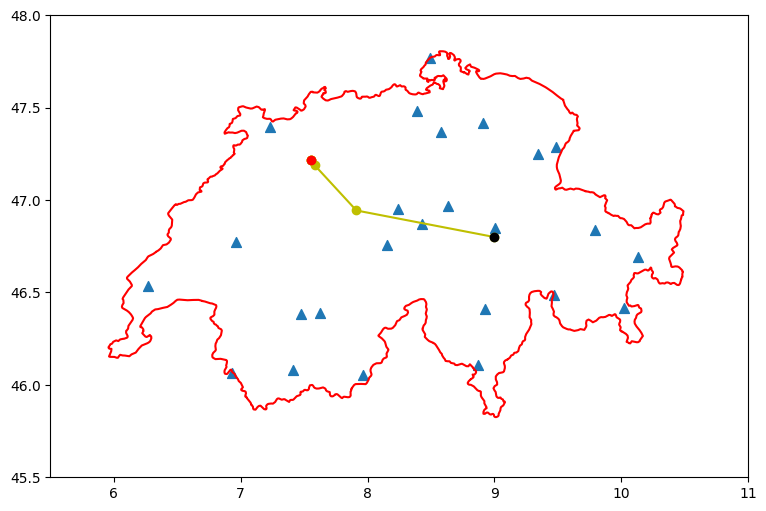

In [4]:
# Earthquake location and plot of iterative solution

######## Start guess for location
x0=9
y0=46.8
z0=-10
tol=[0.01,0.01] # Location tolerances (origin time tolerance, epicentral distance tolerance)
vp=5.8*np.ones_like(ts) # set Seismic wavespeed of medium
#######

# locate earthquake
sols, res =eq.eqlocate(x0,y0,z0,ts,la,lo,el,vp,tol) # here sols are the iterative solutions found, 
                                                    # res is the observed arrival time - minus the predicted arrival time
                                                    # sols returns each iteration of the location procedure
                                                    # This routine will only update the earthquake depth if solvedep=True is given
sol = sols[-1]
tfinal = sols[-1,0] # First parameter is the origin time
xfinal = sols[-1,1] # Second parameter is the Longitude 
yfinal = sols[-1,2] # Third parameter is the Latitude 
zfinal = sols[-1,3] # Fourth parameter is the Depth 

print ('Location', xfinal,yfinal,zfinal)
print ('Event time (seconds after 16:30)',tfinal)

plt.figure(figsize=(9,6))
plt.plot(borderx,bordery,'r-')
plt.scatter(lo,la,s=50,marker='^')
plt.plot(sols[:,1],sols[:,2],'o-y') # solution updates
plt.plot(sols[0,1],sols[0,2],'ok') # initial guess
plt.plot(xfinal,yfinal,'or')
plt.xlim([5.5,11])
plt.ylim([45.5,48])
plt.show()


**Task 2** 

Describe how you would apply the bootstrap to calculate errors in the earthquake location parameters? 

**Task 3** 

Use the bootstrap to calculate 5000 bootstrap solutions and then plot these about the original solution.

Answer: We perform 5000 bootstrap samples of the arrival time residuals and add these to the predicted arrival times, then relocate the event each time. 

In [5]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

tpred = ts - res # get predicted arrival times from residuals

nBoot = 5000 # Number of bootstrap samples
solBoot = np.zeros((nBoot,4))
for i in range(nBoot):
    yBoot = tpred + np.random.choice(res,size=len(res),replace=True) # random sample residuals with replacement
    solsB, resB =eq.eqlocate(x0,y0,z0,yBoot,la,lo,el,vp,tol) # here sols are the iterative solutions found, 
    solBoot[i] = solsB[-1] # bootstrap solution

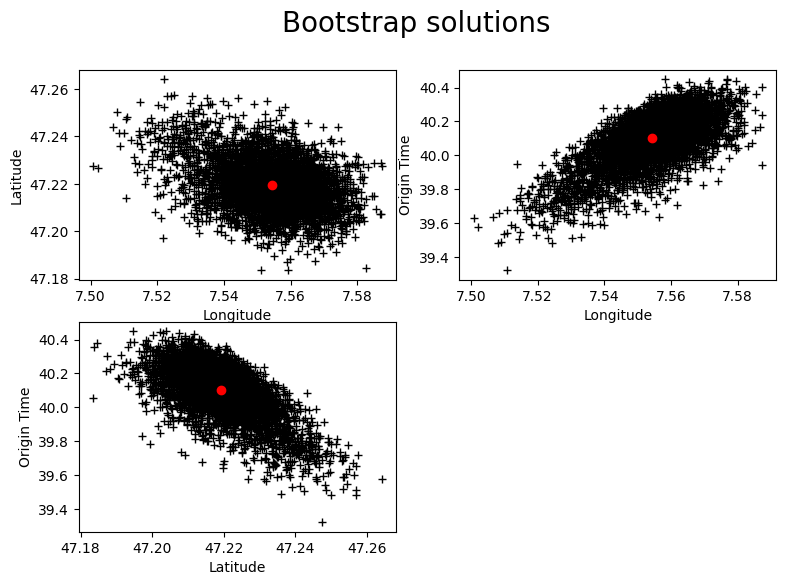

In [6]:
# Now we plot the bootstrap solutions
eq.plot_eq_solutions(solBoot,sols,title="Bootstrap solutions")


**Task 4:** 

From the bootstrap output samples
$(x_1^i, y_2^i, z_3^i), (i=1,\dots, B)$ calculate the i) <span>**the mean bootstrap solution**</span>, ii) <span>**the model
co-variance**</span>, iii) <span>**the bias corrected solution**</span>,
and iv) <span>**the 95% confidence intervals**</span> for each of the unknowns. The bias correction is the mean of the differences between each Bootstrap solution and the estimator itself, which in this case is the best fit solution. This is subtracted from the best fit to produce the  <span>**the bias corrected solution**</span> as described in the notes.

The mean should look similar to the best fit values and
the bias should be small. The variance and confidence intervals
characterize the error in the estimated values of the unknowns.



Answer: A covariance matrix can be calculated from the ensemble of solutions.

In [7]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

cov = np.cov(solBoot.T)
# Bootstrap mean
print(' Bootstrap mean solution\n',np.mean(solBoot,axis=0))
print(' Bootstrap covariance \n',cov)
bcsol = sol - (np.mean(solBoot,axis=0)-sol)
print(' Bootstrap bias corrected solution\n',bcsol)
p = np.percentile(solBoot,[2.5,97.5],axis=0)
print(' Bootstrap 95% Confidence intervals: ')
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(bcsol[0],p[0,0],p[1,0]))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(bcsol[1],p[0,1],p[1,1]))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(bcsol[2],p[0,2],p[1,2]))


 Bootstrap mean solution
 [ 40.09657878   7.5543487   47.21935571 -10.        ]
 Bootstrap covariance 
 [[ 2.20943788e-02  1.20388617e-03 -9.61956677e-04  0.00000000e+00]
 [ 1.20388617e-03  1.39745937e-04 -4.19758218e-05  0.00000000e+00]
 [-9.61956677e-04 -4.19758218e-05  9.83556056e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
 Bootstrap bias corrected solution
 [ 40.10357518   7.5543322   47.21934265 -10.        ]
 Bootstrap 95% Confidence intervals: 
 Parameter 1  40.104 [ 39.731,  40.332]
 Parameter 2   7.554 [  7.527,   7.575]
 Parameter 3  47.219 [ 47.201,  47.242]
